In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import numpy as np
import pandas as pd
import os, glob
from IPython.display import display
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)
print(module_path)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/workspace/braintypicality


as_tfds: false
cache_rate: 1.0
centered: false
colab_path: /content/drive/MyDrive/ML_Datasets/ABCD/processed/
colab_splits_path: /content/drive/MyDrive/Developer/braintypicality/dataset/
colab_tumor_path: /content/drive/MyDrive/ML_Datasets/ABCD/tumor/
dataset: BRAIN
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
gen_ood: false
image_size: !!python/tuple
- 96
- 128
- 96
num_channels: 2
ood_ds: DS-SA
select_channel: -1
spacing_pix_dim: 2.0
splits_path: /home/braintypicality/dataset/
tumor_dir_path: /DATA/Users/amahmood/tumor/
uniform_dequantization: false

In [49]:
import datasets
from configs.ve import biggan_default as configs

config = configs.get_config()

config.training.batch_size = 128
config.eval.batch_size = 256
config.data.cache_rate = 0.0

train_ds, eval_ds, _ = datasets.get_dataset(
        config, uniform_dequantization=config.data.uniform_dequantization,
        evaluation=True, ood_eval=False
)

In [50]:
%%time
dists = []
img_intensity_stds = []
inter_sample_stds = []


for x_trn_batch in train_ds:
    x1 = x_trn_batch["image"].as_tensor().cuda()
    idx = torch.randperm(x1.shape[0]).long()
    d = x1 - x1[idx, :]
    d = torch.linalg.norm(d.reshape(x1.shape[0], -1), dim=1)
#     if (d==0).any():
#         print(i, d[d==0])
    dists.append(d.cpu().numpy())
    
    img_std = x1.reshape(x1.shape[0],x1.shape[1], -1).std(-1)
    img_intensity_stds.append(img_std.mean().cpu().numpy())
    inter_sample_stds.append(x1.std(0).mean().cpu().numpy())
    
dists = np.concatenate(dists)
img_intensity_stds = np.asarray(img_intensity_stds)
inter_sample_stds = np.asarray(inter_sample_stds)

CPU times: user 1.98 s, sys: 9.65 s, total: 11.6 s
Wall time: 3min 43s


In [51]:
img_intensity_stds.mean(), inter_sample_stds.mean()

(0.5728001, 0.06830486)

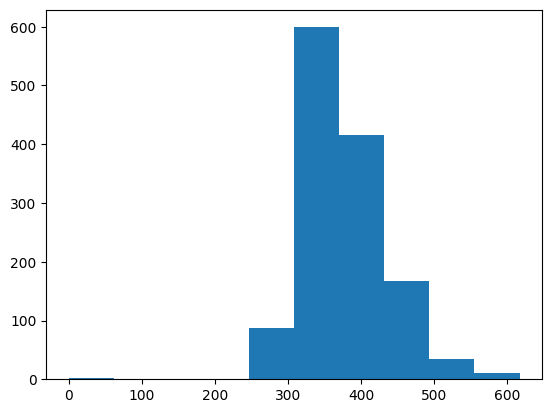

In [52]:
plt.hist(dists);

In [53]:
np.min(dists), np.quantile(dists, 0.99)

(0.0, 544.9425701904296)

In [54]:
x1=x1.cpu()

In [56]:
from configs.ve import biggan_highres as configs
from tqdm.auto import tqdm

hr_config = configs.get_config()

hr_config.eval.batch_size = 64
hr_config.data.cache_rate = 0.0

train_ds, eval_ds, _ = datasets.get_dataset(
        hr_config, uniform_dequantization=config.data.uniform_dequantization,
        evaluation=True, ood_eval=False
)

In [ ]:
%%time

hr_dists = []
hr_inter_sample_stds = []

for x_trn_batch in tqdm(train_ds):
    x1 = x_trn_batch["image"].as_tensor().cuda()
    idx = torch.randperm(x1.shape[0]).long()
    d = x1 - x1[idx, :]
    d = torch.linalg.norm(d.reshape(x1.shape[0], -1), dim=1)
    
    hr_dists.append(d.cpu().numpy())
    hr_inter_sample_stds.append(x1.std(0).mean().cpu().numpy())
    
hr_dists = np.concatenate(hr_dists)
hr_inter_sample_stds = np.asarray(hr_inter_sample_stds)

 38%|███▊      | 8/21 [02:47<01:41,  7.82s/it] 

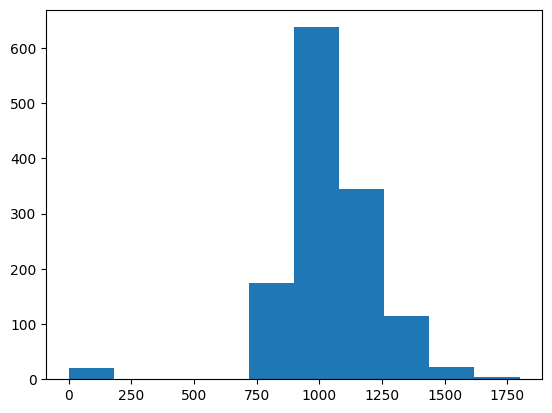

In [61]:
plt.hist(hr_dists);

In [62]:
np.quantile(hr_dists, 0.99)

1507.9526379394524

In [63]:
hr_inter_sample_stds.mean()

0.09218991